I first downloaded the dataset from the google image dataset v7.

I then uploaded the dataset on to drive.

Connected drive with colab using below command.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls /content/drive/MyDrive/YOLO_Dataset/Dataset/train/

Apple  Orange


In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.2/949.2 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

This code splits my Apple data into train and validation sets

80% train and 20% val set

In [4]:
import os
import shutil
import random

# Define paths
dataset_path = "/content/drive/MyDrive/YOLO_Dataset/data"
train_path = os.path.join(dataset_path, "images", "train")
val_path = os.path.join(dataset_path, "images", "val")

train_label_path = os.path.join(dataset_path, "labels", "train")
val_label_path = os.path.join(dataset_path, "labels", "val")

# Create validation folders if not exist
os.makedirs(val_path, exist_ok=True)
os.makedirs(val_label_path, exist_ok=True)

# List all image files
image_files = os.listdir(train_path)
random.shuffle(image_files)

# Define split percentage (e.g., 80% train, 20% val)
split_ratio = 0.2
num_val = int(len(image_files) * split_ratio)

# Move images and corresponding labels to validation set
for img_file in image_files[:num_val]:
    img_path = os.path.join(train_path, img_file)
    label_path = os.path.join(train_label_path, img_file.replace(".jpg", ".txt"))

    shutil.move(img_path, os.path.join(val_path, img_file))
    if os.path.exists(label_path):
        shutil.move(label_path, os.path.join(val_label_path, img_file.replace(".jpg", ".txt")))

print("✅ Validation set created successfully!")


✅ Validation set created successfully!


As the data is not in yolo format we need to convert it into YOLO format to be able to train it

original data labels: Apple 770.731008 5.464 884.736 85.375

YOLO Format: 0 1.293334 0.070968 0.178133 0.124861

In [ ]:
import os

# Define dataset paths
dataset_path = "/content/drive/MyDrive/YOLO_Dataset/data"
classes = {"Apple": 0}  # Add more classes if needed

# Improved function to ensure bounding box stays within valid range (0 to 1)
def convert_to_yolo_safe(class_name, x1, y1, x2, y2, img_width, img_height):
    # Ensure coordinates are within image boundaries
    x1 = max(0, min(x1, img_width))
    y1 = max(0, min(y1, img_height))
    x2 = max(0, min(x2, img_width))
    y2 = max(0, min(y2, img_height))

    # Compute normalized values
    x_center = (x1 + x2) / 2 / img_width
    y_center = (y1 + y2) / 2 / img_height
    width = (x2 - x1) / img_width
    height = (y2 - y1) / img_height

    # Ensure values are clamped between 0 and 1
    x_center = max(0, min(x_center, 1))
    y_center = max(0, min(y_center, 1))
    width = max(0, min(width, 1))
    height = max(0, min(height, 1))

    return f"{classes[class_name]} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"

# Convert labels for train and validation sets
for data_split in ["train", "val"]:
    label_path = os.path.join(dataset_path, "labels", data_split)
    image_path = os.path.join(dataset_path, "images", data_split)

    for file_name in os.listdir(label_path):
        file_path = os.path.join(label_path, file_name)

        with open(file_path, "r") as f:
            lines = f.readlines()

        new_lines = []
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                continue  # Skip malformed labels

            class_name, x1, y1, x2, y2 = parts[0], float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])
            img_width, img_height = 640, 640  # Change based on actual image sizes
            new_lines.append(convert_to_yolo_safe(class_name, x1, y1, x2, y2, img_width, img_height))

        with open(file_path, "w") as f:
            f.write("\n".join(new_lines))

print("✅ Labels converted to YOLO format successfully with bounding box safety checks!")


In [21]:
import os

# Define dataset paths
dataset_path = "/content/drive/MyDrive/YOLO_Dataset/data"

# Ensure bounding box values remain inside [0, 1]
def convert_to_yolo_safe(class_id, x1, y1, x2, y2, img_width, img_height):
    # Convert absolute pixel values to normalized format
    x1, x2 = x1 / img_width, x2 / img_width
    y1, y2 = y1 / img_height, y2 / img_height

    # Ensure coordinates are inside the valid range
    x1, x2 = max(0, min(x1, 1)), max(0, min(x2, 1))
    y1, y2 = max(0, min(y1, 1)), max(0, min(y2, 1))

    # Calculate YOLO format values
    x_center = (x1 + x2) / 2
    y_center = (y1 + y2) / 2
    width = x2 - x1
    height = y2 - y1

    # Ensure bounding box values remain inside [0, 1]
    x_center = max(0, min(x_center, 1))
    y_center = max(0, min(y_center, 1))
    width = max(0.01, min(width, 1))  # Avoid zero-width bounding boxes
    height = max(0.01, min(height, 1))  # Avoid zero-height bounding boxes

    return f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"

# Convert labels for train and validation sets
for data_split in ["train", "val"]:
    label_path = os.path.join(dataset_path, "labels", data_split)

    for file_name in os.listdir(label_path):
        file_path = os.path.join(label_path, file_name)

        with open(file_path, "r") as f:
            lines = f.readlines()

        new_lines = []
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                continue  # Skip malformed labels

            class_id = int(parts[0])  # Read class ID directly
            x1, y1, x2, y2 = float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])
            img_width, img_height = 640, 640  # Adjust based on actual dataset

            # Convert and normalize bounding box
            new_lines.append(convert_to_yolo_safe(class_id, x1, y1, x2, y2, img_width, img_height))

        # Save corrected labels
        with open(file_path, "w") as f:
            f.write("\n".join(new_lines))

print("✅ Bounding box labels corrected successfully!")


✅ Bounding box labels corrected successfully!


yaml file for data training

its essential because it provides dataset structure and provides information required by the YOLO training script.

The train: and val: fields specify where YOLO can find training and validation images.

'nc' defines the total number of object classes in the dataset

'names' maps numerical class IDs to actual object names.


In [22]:
yaml_content = """train: /content/drive/MyDrive/YOLO_Dataset/data/images/train
val: /content/drive/MyDrive/YOLO_Dataset/data/images/val
nc: 1
names: ['Apple']
"""

with open("data.yaml", "w") as f:
    f.write(yaml_content)

print("✅ `data.yaml` created successfully!")


✅ `data.yaml` created successfully!


Training the model

In [23]:
from ultralytics import YOLO

# Load YOLOv8 model
model = YOLO("yolov8s.pt")  # Use "yolov8s.pt" for better accuracy

# Train the model on 50 epohs and img size = 640x640
model.train(data="data.yaml", epochs=50, batch=16, imgsz=640)

print("✅ Training complete!")


Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_widt

train: Scanning /content/drive/MyDrive/YOLO_Dataset/data/labels/train.cache... 64 images, 0 backgrounds, 40 corrupt: 100%|██████████| 64/64 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/drive/MyDrive/YOLO_Dataset/data/images/train/01968ea73417ec3b.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0405      1.1137      1.1137]
train: WARNING ⚠️ /content/drive/MyDrive/YOLO_Dataset/data/images/train/058c086807cea84d.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.5981      1.4536]
train: WARNING ⚠️ /content/drive/MyDrive/YOLO_Dataset/data/images/train/0dad27548e94e6ee.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.2933]
train: WARNING ⚠️ /content/drive/MyDrive/YOLO_Dataset/data/images/train/0e808bb4e4d7d7a4.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.368       1.081      1.3965]
train: WARNING ⚠️ /content/drive/MyDrive/YOLO_Dataset/data/images/train/147ccb810d749f90.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.412]
train: WARNING ⚠️ /content/dri


val: Scanning /content/drive/MyDrive/YOLO_Dataset/data/labels/val.cache... 36 images, 0 backgrounds, 25 corrupt: 100%|██████████| 36/36 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/MyDrive/YOLO_Dataset/data/images/val/02aa2ee596ee27f5.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1225]
val: WARNING ⚠️ /content/drive/MyDrive/YOLO_Dataset/data/images/val/035079488c9216b2.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0275       1.439      1.2006       1.056      1.0465       1.467]
val: WARNING ⚠️ /content/drive/MyDrive/YOLO_Dataset/data/images/val/04806dcd6ad350a4.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0995        1.37]
val: WARNING ⚠️ /content/drive/MyDrive/YOLO_Dataset/data/images/val/05700e985231e8cf.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [      1.355      1.0987      1.0225      1.0425      1.3375      1.1413      1.3487        1.35        1.53      1.2825]
val: WARNING ⚠️ /content/drive/MyDrive/YOLO_Dataset/data/images/val/188579ecec6d3faa.jpg: ignoring corrupt i

Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.06G      3.035      7.271      3.392         18        640: 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         11         13    0.00303      0.769    0.00903    0.00306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.06G      2.759      6.017      3.014         18        640: 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all         11         13    0.00303      0.769     0.0083    0.00305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.06G      2.983      5.304      3.254         28        640: 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.00it/s]

                   all         11         13    0.00303      0.769    0.00778    0.00264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.06G       3.06      5.514      3.119         29        640: 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         11         13    0.00872      0.538     0.0115    0.00348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.09G      2.725      4.317      2.941         18        640: 100%|██████████| 2/2 [00:00<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]

                   all         11         13      0.305     0.0769      0.106     0.0263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.09G      2.544      4.185      2.781         15        640: 100%|██████████| 2/2 [00:00<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]

                   all         11         13      0.229      0.154     0.0848     0.0225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      4.13G      2.156      3.214      2.341         32        640: 100%|██████████| 2/2 [00:00<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.39it/s]

                   all         11         13      0.115      0.231       0.12     0.0501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.13G      2.315      2.906      2.364         27        640: 100%|██████████| 2/2 [00:00<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.33it/s]

                   all         11         13      0.538      0.231      0.223      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.13G      2.143      2.928      2.221         25        640: 100%|██████████| 2/2 [00:00<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]

                   all         11         13      0.346      0.231      0.215      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.13G      2.113      2.849      2.164         17        640: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.95it/s]

                   all         11         13     0.0697      0.231     0.0537     0.0349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.13G      2.059      2.811      2.101         22        640: 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

                   all         11         13     0.0141      0.462     0.0114     0.0039



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.13G      1.961      2.626      2.108         27        640: 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

                   all         11         13     0.0199      0.308     0.0149    0.00522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.13G      2.061      2.541      2.057         26        640: 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         11         13      0.168     0.0769     0.0358     0.0208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.13G      1.764      2.341      1.925         26        640: 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

                   all         11         13      0.157     0.0769     0.0284     0.0159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.13G      1.772      2.281      1.986         23        640: 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.48it/s]

                   all         11         13     0.0123      0.538    0.00985    0.00381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.13G      1.807      2.209      1.984         36        640: 100%|██████████| 2/2 [00:00<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.59it/s]

                   all         11         13    0.00365      0.846    0.00964    0.00279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.13G      2.111      2.711      2.226         14        640: 100%|██████████| 2/2 [00:00<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.23it/s]

                   all         11         13       0.25     0.0769     0.0404      0.011



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.13G      1.929      2.678      2.159         18        640: 100%|██████████| 2/2 [00:00<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.01it/s]

                   all         11         13      0.597     0.0769     0.0938     0.0223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.13G      1.625      2.241      2.006         16        640: 100%|██████████| 2/2 [00:00<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]

                   all         11         13      0.176     0.0769      0.036    0.00799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.13G      1.932      2.349      1.969         23        640: 100%|██████████| 2/2 [00:00<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.38it/s]

                   all         11         13     0.0318      0.308     0.0301    0.00689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.13G      1.778      2.159      1.865         27        640: 100%|██████████| 2/2 [00:00<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.23it/s]

                   all         11         13      0.014      0.308     0.0133    0.00332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.13G      1.801      2.188      1.964         20        640: 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         11         13     0.0957     0.0769     0.0249    0.00401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.13G      1.707      2.305      1.863         23        640: 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]

                   all         11         13      0.669     0.0769     0.0882    0.00975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.13G      1.716      1.991       1.76         20        640: 100%|██████████| 2/2 [00:00<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all         11         13      0.807     0.0769     0.0883     0.0108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.13G      1.662      1.998      2.018         26        640: 100%|██████████| 2/2 [00:00<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

                   all         11         13     0.0334      0.154     0.0242    0.00507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.13G      1.671      1.918      1.885         23        640: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]

                   all         11         13     0.0463      0.231     0.0191    0.00644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.13G      1.664      1.998      1.812         34        640: 100%|██████████| 2/2 [00:00<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.36it/s]

                   all         11         13     0.0707      0.231     0.0496     0.0117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.13G      1.573      2.279      1.963         19        640: 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]

                   all         11         13     0.0707      0.231     0.0496     0.0117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.17G      1.743      2.022      1.803         35        640: 100%|██████████| 2/2 [00:00<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.24it/s]

                   all         11         13      0.083      0.308     0.0617     0.0174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.17G      1.541      1.873      1.764         33        640: 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.21it/s]

                   all         11         13     0.0721      0.308      0.045      0.016



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.17G      1.528      1.755      1.717         36        640: 100%|██████████| 2/2 [00:00<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

                   all         11         13     0.0721      0.308      0.045      0.016



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.17G      1.691      2.114      1.986         17        640: 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

                   all         11         13     0.0785      0.538     0.0615     0.0206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.21G      1.544      1.724      1.825         27        640: 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all         11         13      0.124      0.462      0.084     0.0251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.24G      1.598       1.94      1.823         22        640: 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

                   all         11         13      0.124      0.462      0.084     0.0251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.24G      1.559      1.786      1.816         31        640: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]

                   all         11         13      0.101      0.385      0.108     0.0305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.24G      1.515      1.743      1.653         32        640: 100%|██████████| 2/2 [00:00<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]

                   all         11         13      0.075      0.308     0.0682     0.0223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.24G      1.428      1.649      1.612         23        640: 100%|██████████| 2/2 [00:00<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.74it/s]

                   all         11         13      0.075      0.308     0.0682     0.0223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.28G      1.468      1.572      1.632         35        640: 100%|██████████| 2/2 [00:00<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.88it/s]

                   all         11         13     0.0891      0.385     0.0973     0.0266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.28G      1.496      1.666      1.681         33        640: 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]

                   all         11         13      0.412     0.0769     0.0742     0.0158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.28G      1.253      1.617      1.599         20        640: 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.24it/s]

                   all         11         13      0.412     0.0769     0.0742     0.0158


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.28G      1.236      1.801       1.69         18        640: 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all         11         13       0.71     0.0769      0.111     0.0217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.32G      1.251       1.64      1.639         14        640: 100%|██████████| 2/2 [00:00<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


                   all         11         13       0.38      0.154      0.138     0.0475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.32G      1.115      1.594       1.49          8        640: 100%|██████████| 2/2 [00:00<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all         11         13       0.38      0.154      0.138     0.0475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.32G      1.297      1.557      1.564         15        640: 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all         11         13      0.332      0.308      0.198     0.0709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.32G       1.14      1.444      1.522         16        640: 100%|██████████| 2/2 [00:00<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


                   all         11         13      0.332      0.308      0.198     0.0709

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.34G      1.168      1.474      1.511         18        640: 100%|██████████| 2/2 [00:00<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]

                   all         11         13      0.393      0.308      0.212      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.34G      1.154      1.543       1.61         12        640: 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.60it/s]

                   all         11         13      0.393      0.308      0.212      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.34G       1.11      1.458      1.616         10        640: 100%|██████████| 2/2 [00:00<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

                   all         11         13      0.254      0.308      0.208      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.34G      1.073      1.273      1.519         15        640: 100%|██████████| 2/2 [00:00<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]

                   all         11         13      0.254      0.308      0.208      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.34G      1.052       1.34      1.423          9        640: 100%|██████████| 2/2 [00:00<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]

                   all         11         13      0.382      0.308      0.257      0.147



50 epochs completed in 0.020 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 22.5MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]


                   all         11         13      0.543      0.231      0.223      0.186
Speed: 0.2ms preprocess, 4.2ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train3
✅ Training complete!


Loading the trained model for predictions

In [24]:
from ultralytics import YOLO

# Load trained model
model = YOLO("runs/detect/train/weights/best.pt")

from google.colab import files
uploaded = files.upload()  # Upload an image from your system

image_path = list(uploaded.keys())[0]


Saving 7a257749c84458d7.jpg to 7a257749c84458d7.jpg



image 1/1 /content/7a257749c84458d7.jpg: 640x480 2 Apples, 48.1ms
Speed: 3.4ms preprocess, 48.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


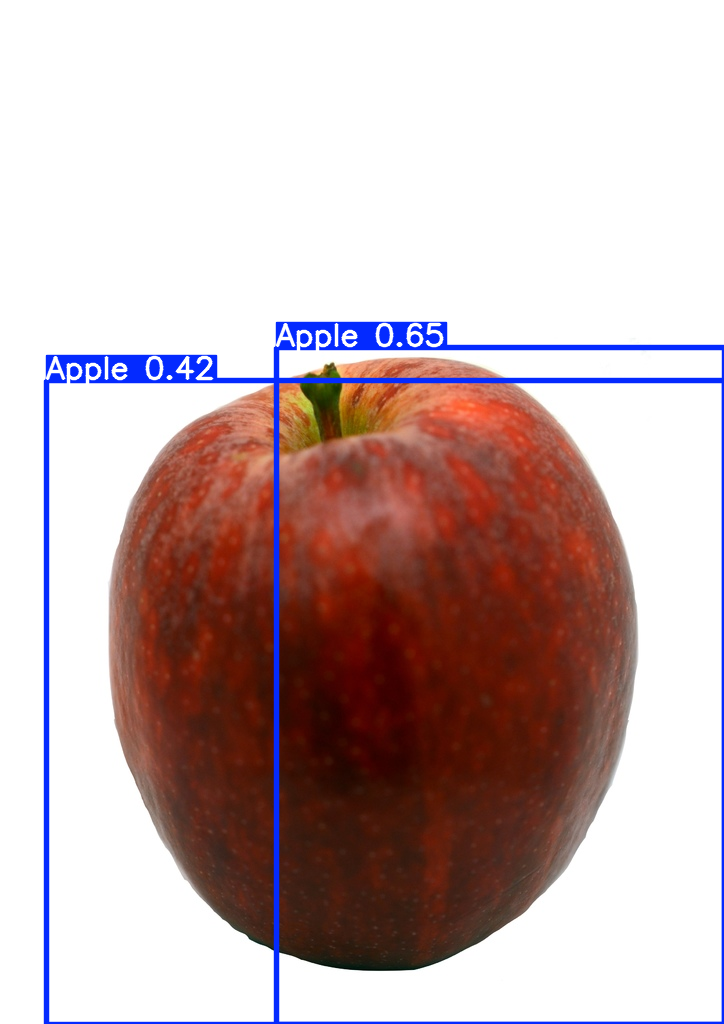

In [25]:
results = model(image_path)  # Perform inference

# Display the image with bounding boxes
results[0].show()

Conclusion: Although the predictions are not accurate but we now know how to download, prepare and train the data using YOLOv8 with more fine tuning we can improve the accuracy of the model

increasing the dataset, increasing the epochs and further normalizing the dataset can help